In [5]:
import pandas as pd
pd.set_option('display.max_columns',100)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, log_loss, roc_auc_score, hamming_loss, fbeta_score, auc, roc_curve, precision_score, recall_score
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer, KNNImputer 
from sklearn import preprocessing
from sklearn import utils

In [12]:
df = pd.read_csv('bank.csv', delimiter = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,58.0,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44.0,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33.0,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47.0,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33.0,unknown,single,unknown,no,1,no,no,NaN,5,may,198,1,-1,0,unknown,no


In [349]:
df.shape

(45211, 17)

Below indicates there are 10 catagorical and 7 numerical features.

The dependent variable, deposit, leaves 16 remaining independent variables. 

The data was collected between 2008 and 2010 for the purposes of encouraging poeple to sign up for term deposits. The dataset has 45211 rows and 11.7% of people siad yes. 

In [185]:
df.dtypes

age          float64
job           object
marital       object
education     object
default       object
balance        int64
housing       object
loan          object
contact       object
day            int64
month         object
duration       int64
campaign       int64
pdays          int64
previous       int64
poutcome      object
deposit       object
dtype: object

Lets look into the data to get a sense of what needs to be done in the processing phase.

The combination of graphs and raw data is best to get a general understanding while having the raw data to back up any thoughts. 










Lets start with our 7 numerical features. First lets get a general feel for the data visually. 


Day is spread out as expected. Age is normally distributed with an average of 40.9

I can see outliers to remove for previous, pdays > 500, campaign >25 , balance > 50000.
    Duration has an outlier of around 5000 seconds. That is an hour and 23 minutes, which i thought wasnt that unrealistic so i kept it. 

Previous with amean of .58 and a max of 275 implies that there is a major rightward skew in that distobution. I will remove this column. 


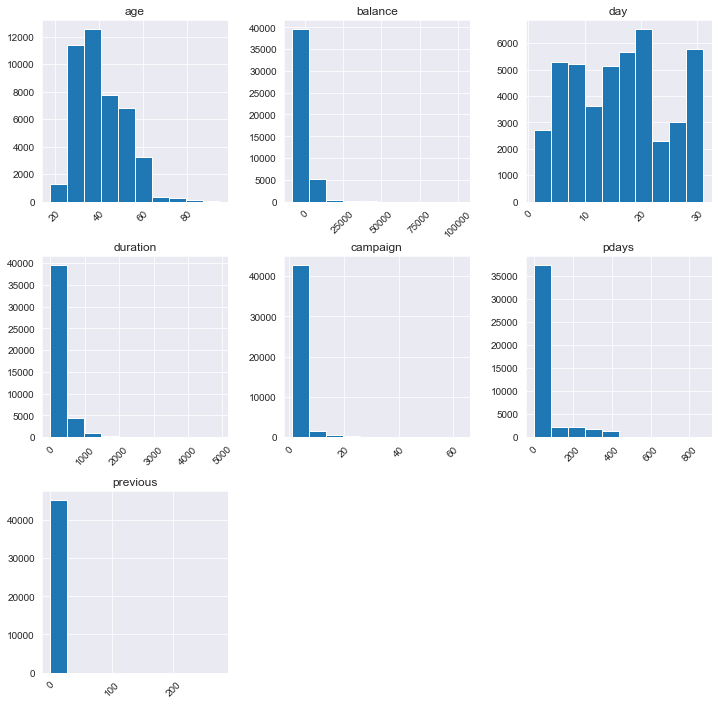

In [285]:
df.hist(figsize=(12,12), xrot=45)
plt.show()

In [81]:
#Summary Statistics
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,43872.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.924781,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.610835,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


Now lets see how each of the numerical variables correlates to deposit. 

From the boxplots below, duration and pdays have the biggest effect

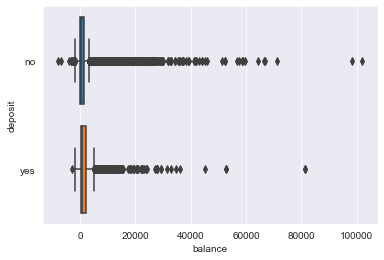

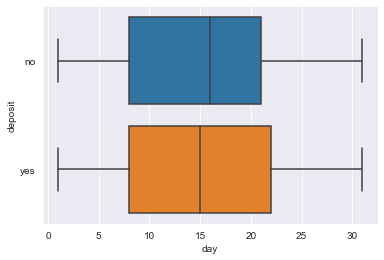

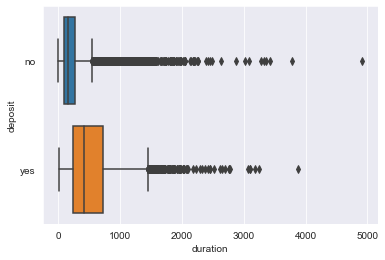

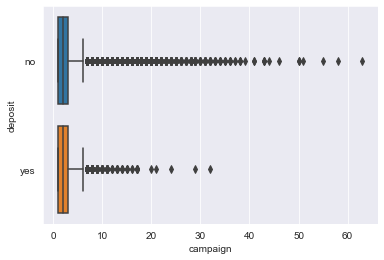

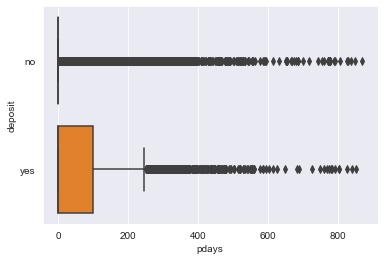

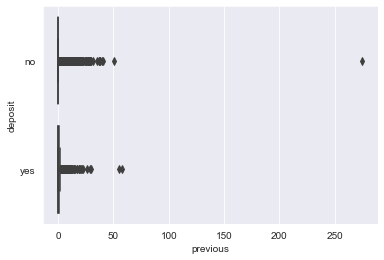

In [75]:
#This code compares all numerical columns to the depenedednt catagorical variable
for column in df.select_dtypes(include='int64'):
 sns.boxplot(y='deposit', x=column, data=df)
 plt.show()

Now lets look for any strong correlations between numerical features and the dependent variable. 

Overall very week correlations. With the strongest being duration at .098 - yes thats .098 not .98.

<AxesSubplot:>

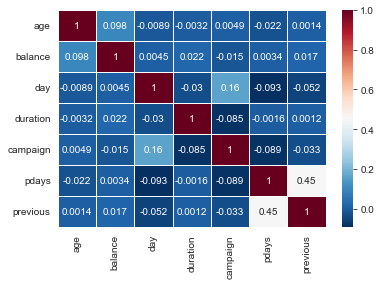

In [80]:
pearsoncorr = df.corr(method='pearson')
sns.heatmap(pearsoncorr,
xticklabels=pearsoncorr.columns, yticklabels=pearsoncorr.columns, cmap='RdBu_r',
annot=True,
            linewidth=0.5)

Now lets look into catagorical variables

Below indicates that the poutcome variable is obsolete - with 37000/45000 unknown. the deposit varibel has a nice ratio of yes/no to help develeop a predictive model - roughly 1 in 8. 

In [50]:
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,45211,45211,45211,43905,45211,45211,43828,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,43113,25130,37967,28410,13766,36959,39922


Bleow incates that a disproportionately large portion of people in the dataset are mariried, college educated.

The default yes/no ratio as visualized below is 43113/43905. This feature will be removed.

I am surprised to see this many people with housing loans, but isnt concerning. 

Not sure how useful contact is either. This feature will be removed.


Note that day is not showing up because ti only nriong up features with less than 10 classes. I determined that the day of themonth, once broken into dummy vairbale, will only compicate the model. This featurew will be rmeoved. 



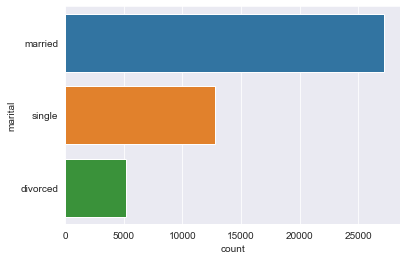

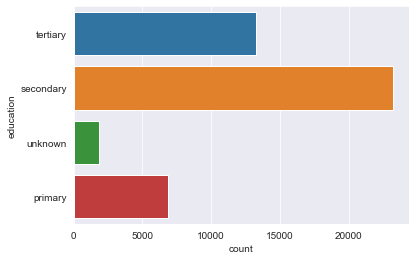

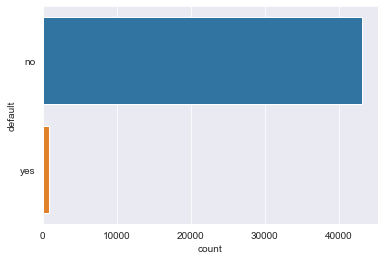

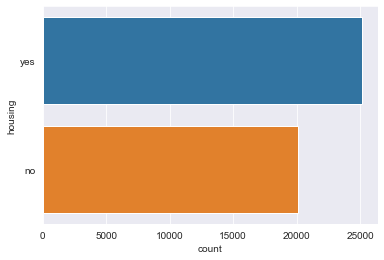

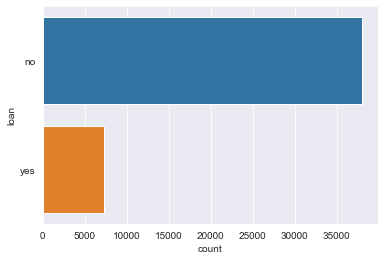

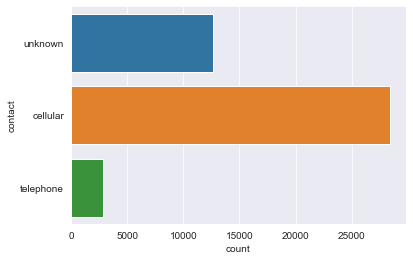

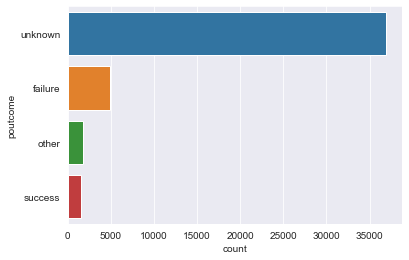

In [63]:
for column in df.select_dtypes(include='object'):
    if df[column].nunique() < 10:
        sns.countplot(y=column, data=df)
        plt.show()

Now lets see how how these catagorical features relate to each numericle feature. 

In other words, below displays the mean of each numerical variable after grouping by the classes of each catagorical feature. 


As a refernce to know this code is workiong. The average balance for those that default is - 136 while those that have not have an average balance of 1390. Lets see if any person who has defaultyed has also taken out a loan. 

In [77]:
for column in df.select_dtypes(include='object'):
    if df[column].nunique() < 10:
        display(df.groupby(column).mean())

,age,balance,day,duration,campaign,pdays,previous
marital,,,,,,,
divorced,45.745199,1178.872287,15.796428,262.517188,2.630882,41.001728,0.551373
married,43.398160,1425.925590,15.854487,253.412765,2.842875,37.950467,0.556552
single,33.700532,1301.497654,15.708210,266.497967,2.649805,44.652385,0.642690


,age,balance,day,duration,campaign,pdays,previous
education,,,,,,,
primary,45.881307,1250.949934,15.421398,255.933002,2.834331,36.081740,0.489272
secondary,39.965556,1154.880786,15.759159,258.685760,2.700802,42.353504,0.567753
tertiary,39.550372,1758.416435,16.086535,258.518532,2.825577,39.024134,0.661980
unknown,44.502222,1526.754443,15.810985,257.313947,2.849219,36.856220,0.488422


,age,balance,day,duration,campaign,pdays,previous
default,,,,,,,
no,40.947319,1390.827685,15.796048,258.888108,2.756338,40.643425,0.586343
yes,39.428385,-136.917929,16.396465,241.085859,3.170455,18.473485,0.268939


,age,balance,day,duration,campaign,pdays,previous
housing,,,,,,,
no,43.140375,1596.501270,16.066929,256.700911,2.845625,26.288581,0.484787
yes,39.159438,1175.103064,15.598249,259.331476,2.698488,51.312495,0.656665


,age,balance,day,duration,campaign,pdays,previous
loan,,,,,,,
no,40.998346,1474.453631,15.765085,259.559275,2.750336,41.192983,0.591435
yes,40.536425,774.309912,16.023054,250.845389,2.834622,34.982054,0.522087


,age,balance,day,duration,campaign,pdays,previous
contact,,,,,,,
cellular,40.395535,1402.469729,15.945829,262.906371,2.691482,56.972017,0.805843
telephone,47.725806,1812.229263,16.578142,232.929512,3.385190,45.758633,0.815237
unknown,40.601209,1174.541994,15.346181,252.361805,2.789278,1.257911,0.021572


,age,balance,day,duration,campaign,pdays,previous
poutcome,,,,,,,
failure,40.793994,1465.805550,14.166701,244.185880,1.980820,241.509284,2.896552
other,39.764871,1487.411413,14.475000,255.715217,2.461413,229.683696,4.009239
success,43.062201,1939.301125,14.449371,316.868961,1.806089,163.259431,3.075447
unknown,40.912589,1318.722043,16.145621,257.738332,2.921886,-0.962039,0.000460


,age,balance,day,duration,campaign,pdays,previous
deposit,,,,,,,
no,40.829691,1303.714969,15.892290,221.182806,2.846350,36.421372,0.502154
yes,41.645609,1804.267915,15.158253,537.294574,2.141047,68.702968,1.170354


Now lets move on to pre-proccessing

After the above analysis i have determined to










In [13]:
#Change deposit from yes no to binanry
df['deposit'] = [0 if (df['deposit'][i] == 'yes') else 1 for i in range(len(df))]

In [14]:
#Remove columns - default, contact, previous, day
df = df.drop(['day', 'previous', 'contact', 'default'], axis = 1)

In [15]:
#Remove outliers
df = df[(df["pdays"] < 400) & (df["campaign"] < 15) & (df["balance"] < 20000)]

In [244]:
df.shape

(44176, 13)

45211-44176   - 1036 rows with outliers were removed. 

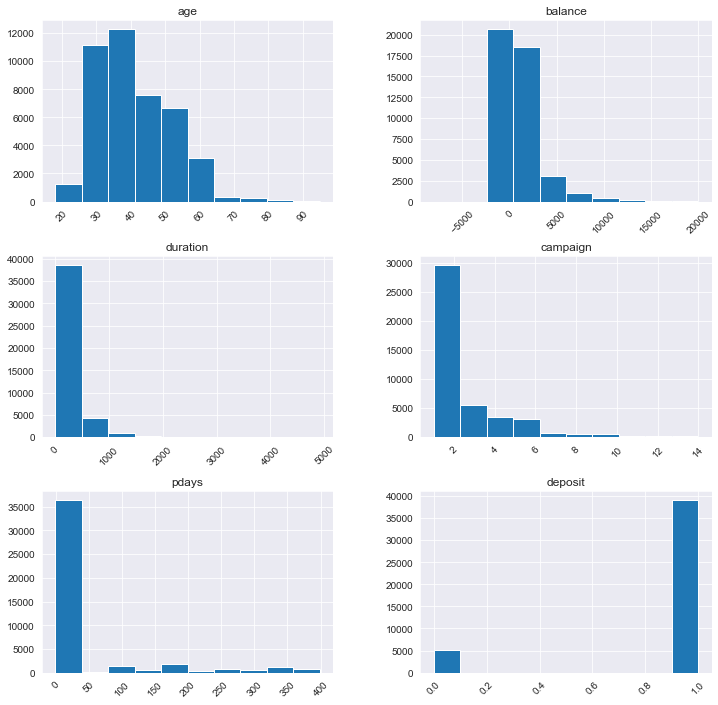

In [149]:
df.hist(figsize=(12,12), xrot=45)
plt.show()

In [411]:
#Remove NA values
df.isna().sum(0)

age          1305
job             0
marital         0
education       0
balance         0
housing         0
loan            0
month           0
duration        0
campaign        0
pdays           0
poutcome        0
deposit         0
dtype: int64

1035 is a similar amount of rows removed for outliers. I personally prefer removing nulls over imputing values in - assuming my dataset is big enough.

In [16]:
df = df.dropna()

In [413]:
df.shape

(42871, 13)

Now i need to scale the numerical data - the columns below. 

Becuase I manually handled aoutliers. I decided against the robusst scalr - whichis simialr to the MinMax bur uses the interquartile rtange - and instead chose the MinMax scalar. 

For another time. I will make sure to only scale the numerical data. 

age                    float64
balance                  int64
duration                 int64
campaign                 int64
pdays                    int64
deposit                  int64

In [17]:
df_scale = df[['age', 'balance', 'duration', 'campaign', 'pdays']]
scaler = MinMaxScaler()
df_scale = scaler.fit_transform(df_scale.to_numpy())
df_scaled = pd.DataFrame(df_scale, columns=['age', 'balance', 'duration', 'campaign', 'pdays'])
df_scaled.shape

(42871, 5)

In [18]:
df = df.drop(['age', 'balance', 'duration', 'campaign', 'pdays'], axis = 1)
df.shape

(42871, 8)

In [19]:
df_scaled.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)
bank = pd.concat([df_scaled, df], axis=1)
bank

,age,balance,duration,campaign,pdays,job,marital,education,housing,loan,month,poutcome,deposit
0,0.519481,0.362877,0.053070,0.000000,0.0000,management,married,tertiary,yes,no,may,unknown,1
1,0.337662,0.287388,0.030704,0.000000,0.0000,technician,single,secondary,yes,no,may,unknown,1
2,0.194805,0.286423,0.015453,0.000000,0.0000,entrepreneur,married,secondary,yes,yes,may,unknown,1
3,0.376623,0.340130,0.018707,0.000000,0.0000,blue-collar,married,unknown,yes,no,may,unknown,1
4,0.194805,0.286388,0.040260,0.000000,0.0000,unknown,single,unknown,no,no,may,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42866,0.428571,0.315812,0.198658,0.153846,0.0000,technician,married,tertiary,no,no,nov,unknown,0
42867,0.688312,0.348093,0.092721,0.076923,0.0000,retired,divorced,primary,no,no,nov,unknown,0
42868,0.701299,0.490430,0.229158,0.307692,0.4625,retired,married,secondary,no,no,nov,success,0
42869,0.506494,0.310206,0.103294,0.230769,0.0000,blue-collar,married,secondary,no,no,nov,unknown,1


Create Dummy variables - for catagorical variables. 

Reduce redundancy -  Utilized the drop_first=True command. This removes one class (the first alphabetically) from each feature. Essential limiting the column by 1 for each feature. Avoid the Dummy Variable Trap caused by multicollinearity across the features. Also enables us to have a refernce (one class from each feature). 

In [20]:
#Create Dummy Variables
bank2 = pd.get_dummies(bank, drop_first=True)
bank2.shape

(42871, 38)

In [21]:
bank2.head()

,age,balance,duration,campaign,pdays,deposit,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,housing_yes,loan_yes,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,0.519481,0.362877,0.053070,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.337662,0.287388,0.030704,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,0.194805,0.286423,0.015453,0.0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,0.376623,0.340130,0.018707,0.0,0.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,0.194805,0.286388,0.040260,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


It is finally time to start creating the model. In this case we need a supervised model. We know the inpout and ouput vaiables - simply just need to predict the deposit is either yes or no. 

Now lets break out data into test and training stes and find the best model. 

In [22]:
X = bank2.drop(columns='deposit')
y = bank2['deposit']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,shuffle=True)

12 different classifiers were used in order to be able to assess whic model performs the best. 

In [23]:
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    BernoulliNB(),
    MLPClassifier(),
    MLPClassifier(hidden_layer_sizes=[100, 100]),
    LinearDiscriminantAnalysis(), 
    LogisticRegression(), 
    QuadraticDiscriminantAnalysis(),
]

In [24]:
log_cols=["Classifier", "Accuracy", "Log Loss", "F1 Score", "ROC", "Precision", "Recall", "Sensitivity", "Specificity","True Positives"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers: 
    clf.fit(X_train, y_train) 
    name = clf.__class__.__name__
    train_predictions = clf.predict(X_test)
    
    #Accuracy
    acc_ = accuracy_score(y_test, train_predictions)
    acc = acc_.round(3)
    #Log Loss
    ll_ = log_loss(y_test, train_predictions)
    ll = ll_.round(3)
    #F1
    fbeta_ = fbeta_score(y_test, train_predictions, beta=1) 
    fbeta = fbeta_.round(3)
    #AUC (ROC)
    roc_ = roc_auc_score(y_test, train_predictions)
    roc = roc_.round(3)
    #Precision
    precision_ = precision_score(y_test, train_predictions, average='binary') 
    precision = precision_.round(3)
    #Recall
    recall_ = recall_score(y_test, train_predictions)
    recall = recall_.round(3)
    #Sensitivity
    TP = confusion_matrix(y_test,train_predictions).ravel()[0]
    FN = confusion_matrix(y_test,train_predictions).ravel()[1]
    sensitivity_ = TP / (TP + FN)
    sensitivity = sensitivity_.round(3)
    #Specificity
    TN = confusion_matrix(y_test,train_predictions).ravel()[3]
    FP = confusion_matrix(y_test,train_predictions).ravel()[2]
    specificity_ = TN / (TN + FP)
    specificity = specificity_.round(3)
    #True Positives
    true_positives = confusion_matrix(y_test,train_predictions).ravel()[0] 
    #Confusion Matrix
    confusion_matrix_ = confusion_matrix(y_test, train_predictions) 
    print(f"Confusion matrix: \n{confusion_matrix_}\n")
    
    
    
    log_entry = pd.DataFrame([[name, acc*100, ll, fbeta, roc, precision, recall, sensitivity, specificity, true_positives]], columns=log_cols)
    log = pd.concat([log,log_entry])

Confusion matrix: 
[[  379  1112]
 [  395 10976]]

Confusion matrix: 
[[  614   877]
 [  879 10492]]

Confusion matrix: 
[[  579   912]
 [  344 11027]]

Confusion matrix: 
[[  476  1015]
 [  298 11073]]

Confusion matrix: 
[[  530   961]
 [  304 11067]]

Confusion matrix: 
[[  622   869]
 [  805 10566]]

Confusion matrix: 
[[  438  1053]
 [  583 10788]]



/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion matrix: 
[[  562   929]
 [  356 11015]]



/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion matrix: 
[[  666   825]
 [  639 10732]]

Confusion matrix: 
[[  604   887]
 [  414 10957]]

Confusion matrix: 
[[  418  1073]
 [  227 11144]]

Confusion matrix: 
[[  638   853]
 [  834 10537]]



<AxesSubplot:ylabel='Classifier'>

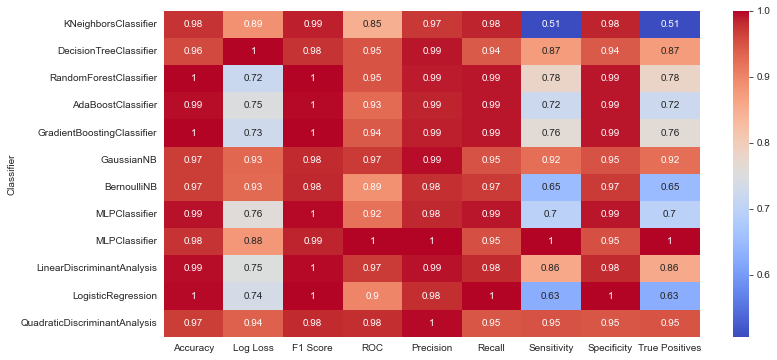

In [444]:
loga = log.set_index('Classifier')
norm_df = loga / loga.max(0)
plt.figure(figsize=(12,6)) 
sns.heatmap(norm_df.astype('float'),cmap='coolwarm',annot=True)

In [447]:
loga

,Accuracy,Log Loss,F1 Score,ROC,Precision,Recall,Sensitivity,Specificity,True Positives
Classifier,,,,,,,,,
KNeighborsClassifier,88.3,4.058,0.936,0.611,0.908,0.964,0.257,0.964,382
DecisionTreeClassifier,86.7,4.579,0.925,0.683,0.927,0.923,0.443,0.923,659
RandomForestClassifier,90.5,3.295,0.947,0.683,0.925,0.971,0.396,0.971,589
AdaBoostClassifier,90.0,3.437,0.945,0.668,0.921,0.970,0.366,0.970,544
GradientBoostingClassifier,90.4,3.330,0.947,0.679,0.924,0.971,0.387,0.971,576
GaussianNB,87.7,4.262,0.930,0.699,0.930,0.930,0.468,0.930,697
BernoulliNB,87.7,4.254,0.932,0.639,0.915,0.949,0.329,0.949,489
MLPClassifier,89.9,3.480,0.945,0.662,0.920,0.971,0.353,0.971,525
MLPClassifier,88.3,4.025,0.934,0.720,0.935,0.933,0.507,0.933,755


What does all this above mean? 

Lets connect it back to the business problem. The business desires the ability to predict if someone will make a deposit. Given a new list, our model will make a predict whether each individual will make a deposit. If we guess that someone will, call them and they actually do, this is a true positive, and this is what we want to maximize.


I want to narrow down the table to only the columns with metrics that prioritize True Positives - that is precision  and Recall. Make a new column which is the average of them both. and then sort by desc to find the best classifier. 

In [456]:
final = loga[['Precision', 'Recall']]
fin = loga.loc[: , "Precision":"Recall"]
#final['avg'] = final['Precision']+ final['Recall']/2
final['avg'] = fin.mean(axis=1)
final = final.sort_values(by='avg', ascending=False)
final

/var/folders/cq/v_1yg9f54bd7z64s5xj602cr0000gn/T/ipykernel_20844/2753695959.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['avg'] = fin.mean(axis=1)


,Precision,Recall,avg
Classifier,,,
RandomForestClassifier,0.925,0.971,0.9480
GradientBoostingClassifier,0.924,0.971,0.9475
LogisticRegression,0.916,0.979,0.9475
AdaBoostClassifier,0.921,0.970,0.9455
MLPClassifier,0.920,0.971,0.9455
LinearDiscriminantAnalysis,0.929,0.961,0.9450
KNeighborsClassifier,0.908,0.964,0.9360
MLPClassifier,0.935,0.933,0.9340
BernoulliNB,0.915,0.949,0.9320


Random forest calssifier is the best!